In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# df_weather_train = pd.read_csv("../ashrae-energy-prediction/train.csv")
df_weather_train = pd.read_csv("train.csv")
df_weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [11]:
# Load the dataset (assuming you've already read it)
df_weather_train.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [12]:
df_weather_train.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

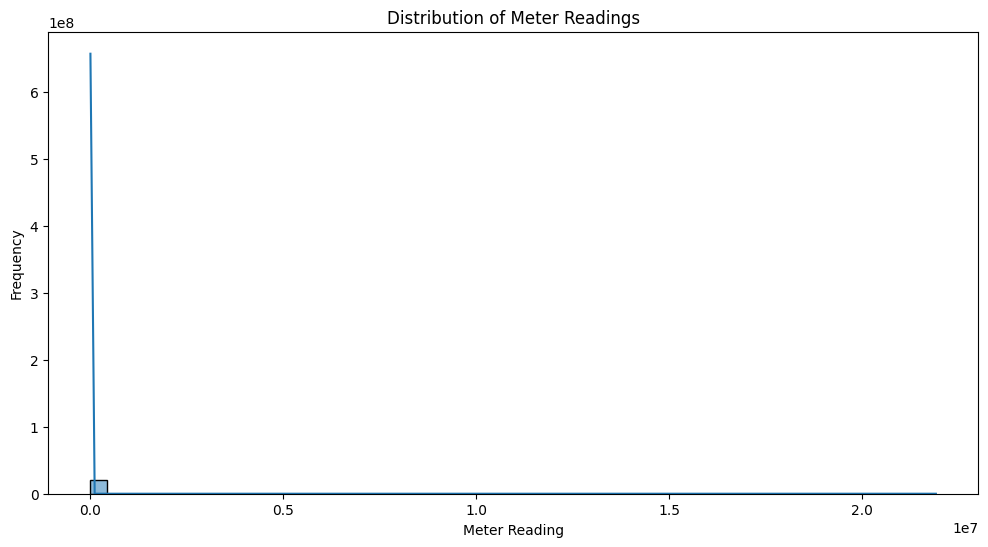

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.histplot(df_weather_train["meter_reading"], bins=50, kde=True)
plt.xlabel("Meter Reading")
plt.ylabel("Frequency")
plt.title("Distribution of Meter Readings")
plt.show()

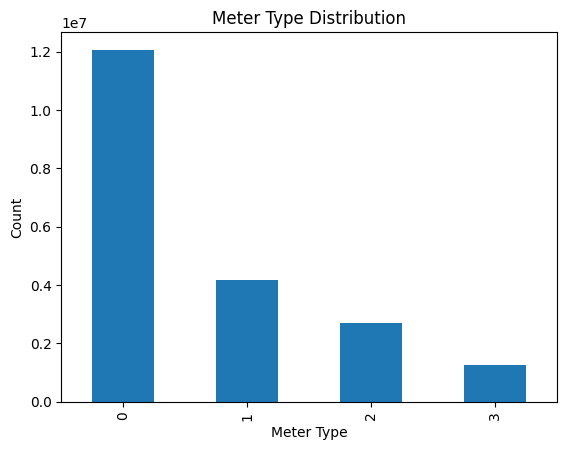

In [14]:
df_weather_train["meter"].value_counts().plot(kind="bar", title="Meter Type Distribution")
plt.xlabel("Meter Type")
plt.ylabel("Count")
plt.show()

In [15]:
df_weather_train["timestamp"] = pd.to_datetime(df_weather_train["timestamp"])
df_weather_train["hour"] = df_weather_train["timestamp"].dt.hour
df_weather_train["day"] = df_weather_train["timestamp"].dt.day
df_weather_train["month"] = df_weather_train["timestamp"].dt.month
df_weather_train["year"] = df_weather_train["timestamp"].dt.year

In [17]:
print(df_weather_train.tail())

          building_id  meter           timestamp  meter_reading  hour  day  \
20216095         1444      0 2016-12-31 23:00:00          8.750    23   31   
20216096         1445      0 2016-12-31 23:00:00          4.825    23   31   
20216097         1446      0 2016-12-31 23:00:00          0.000    23   31   
20216098         1447      0 2016-12-31 23:00:00        159.575    23   31   
20216099         1448      0 2016-12-31 23:00:00          2.850    23   31   

          month  year  
20216095     12  2016  
20216096     12  2016  
20216097     12  2016  
20216098     12  2016  
20216099     12  2016  
